Install Dependencies

In [1]:
!pip install kaggle tensorflow scikit-learn matplotlib seaborn


Upload Kaggle API Key

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinrajkdinesh","key":"3820967f07e7d9577c408d1c73d729a7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Download Dataset via CLI

In [4]:
!kaggle datasets download -d saurabhshahane/fake-news-classification
!unzip fake-news-classification.zip


Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/92.1M [00:00<?, ?B/s]
100% 92.1M/92.1M [00:00<00:00, 1.72GB/s]
Archive:  fake-news-classification.zip
  inflating: WELFake_Dataset.csv     


Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional,
    Dense, Dropout, SpatialDropout1D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Load Dataset

In [6]:
df = pd.read_csv("WELFake_Dataset.csv")

print(df.head())
print(df.shape)


   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
(72134, 4)


Basic Cleaning

In [7]:
df = df.dropna()
df = df.drop_duplicates()

print(df.shape)
print(df['label'].value_counts())


(71537, 4)
label
1    36509
0    35028
Name: count, dtype: int64


In [9]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

Combine Title + Text

In [13]:
df['content'] = df['title'] + " " + df['text']


Length Distribution Analysis

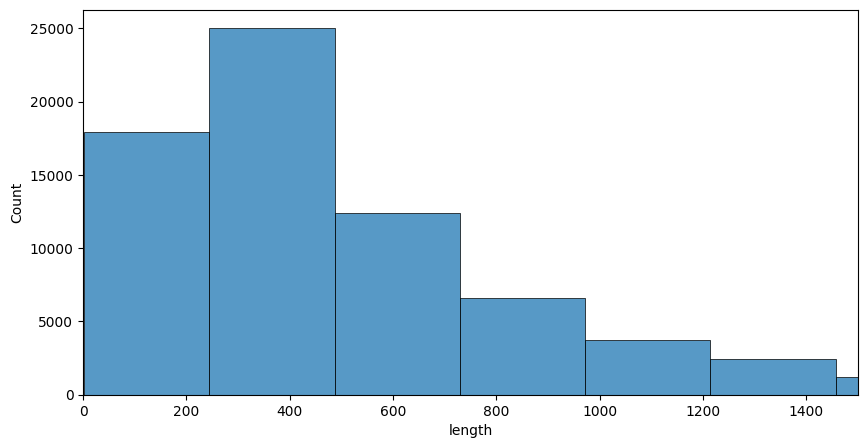

Average length: 556.8285083243636
95th percentile: 1432.0


In [15]:
df['length'] = df['content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df['length'], bins=100)
plt.xlim(0,1500)
plt.show()

print("Average length:", df['length'].mean())
print("95th percentile:", np.percentile(df['length'], 95))


In [18]:
MAX_LEN = 500


Tokenization

In [19]:
VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content'])

sequences = tokenizer.texts_to_sequences(df['content'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

X = padded
y = df['label'].values

print("X shape:", X.shape)


X shape: (71537, 500)


Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Model Architecture

In [21]:
model = Sequential([
    Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Callbacks

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


Train Model

In [23]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.8692 - loss: 0.2617 - val_accuracy: 0.9668 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.9857 - loss: 0.0463 - val_accuracy: 0.9699 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.9939 - loss: 0.0190 - val_accuracy: 0.9638 - val_loss: 0.1027 - learning_rate: 0.0010
Epoch 4/10
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9952 - loss: 0.0143
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
403/403 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9952 - loss: 0.0143 - val_accuracy: 0.9736 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 5/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9743 - val_loss: 0.1249 - learning_rate: 5.0000e-04


Evaluation

In [24]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7006
           1       0.97      0.98      0.97      7302

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308

ROC-AUC: 0.9961227231532106


Confusion Matrix

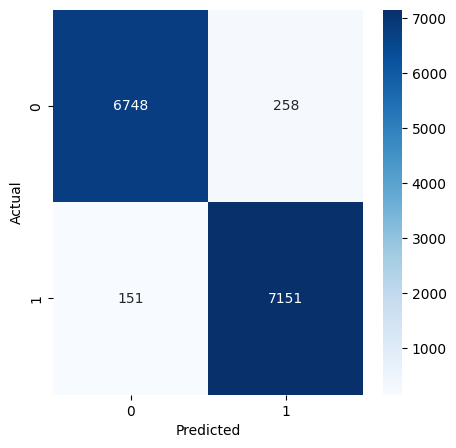

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Save Model

In [26]:
model.save("fake_news_bilstm.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


Testing Model

In [34]:
y_pred_prob = model.predict(X_test)
print("Mean prediction:", np.mean(y_pred_prob))
print("Min:", np.min(y_pred_prob))
print("Max:", np.max(y_pred_prob))


448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
Mean prediction: 0.51708853
Min: 1.9424754e-06
Max: 0.9999999


In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, (y_pred_prob > 0.5))
print(cm)


[[6748  258]
 [ 151 7151]]


In [37]:
# Get misclassified examples
misclassified = X_test[(y_pred.flatten() != y_test)]

print("Total misclassified:", len(misclassified))


Total misclassified: 409


In [54]:
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
loaded_model = tf.keras.models.load_model("fake_news_bilstm.h5")

# Load the tokenizer
with open("tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)

# Define MAX_LEN (should be the same as used during training)
# MAX_LEN = 500  # This was already defined in the notebook

def predict_news(text):

    sequence = loaded_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(
        sequence,
        maxlen=MAX_LEN,
        padding='post',
        truncating='post'
    )

    prediction = loaded_model.predict(padded_sequence)[0][0]

    if prediction > 0.5:
        return "Real News", prediction
    else:
        return "Fake News", prediction


# Example usage:
example_news_fake = "Trump says Brexit to be 'a great thing', wants quick trade deal with UK. LONDON (Reuters) - U.S. President-elect Donald Trump said that Brexit would turn out to be a great thing wants quick trade edal with UK "
example_news_real = "THE ROBBING OF INNOCENCE: 12 Yr Old Students Given CDC Survey About Transgender, Gay And Oral Sex.The left believes these are all perfectly acceptable topics to discuss with our young children. "
example_news_fake_1 = "U.S. House votes to slap back Trump’s tariffs on Canada. The House has voted to slap back President Donald Trump’s tariffs on Canada, a rare if largely symbolic rebuke of the White House agenda as Republicans joined Democrats over the objections of GOP leadership."

result_fake, prob_fake = predict_news(example_news_fake)
result_real, prob_real = predict_news(example_news_real)
result_fake_1, prob_fake_1 = predict_news(example_news_fake_1)

print(f"'{{example_news_fake}}' is predicted as: {result_fake} (Probability: {prob_fake:.4f})")
print(f"'{{example_news_real}}' is predicted as: {result_real} (Probability: {prob_real:.4f})")
print(f"'{{example_news_fake_1}}' is predicted as: {result_fake_1} (Probability: {prob_fake_1:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
'{example_news_fake}' is predicted as: Fake News (Probability: 0.0050)
'{example_news_real}' is predicted as: Real News (Probability: 0.9983)
'{example_news_fake_1}' is predicted as: Real News (Probability: 0.9130)


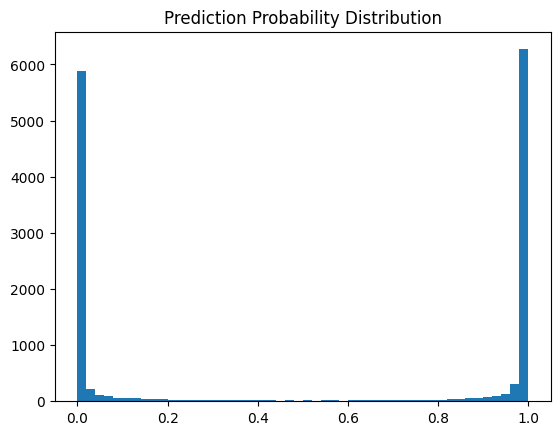

In [44]:
plt.hist(y_pred_prob, bins=50)
plt.title("Prediction Probability Distribution")
plt.show()


### Analysis of Misclassification

Upon inspecting the tokenized words for the real news article "Latest Pipeline Leak Underscores Dangers Of Dakota Access Pipeline", we observe the following:

1.  **Vocabulary Overlap**: Words like 'leak', 'underscores', and 'dangers' convey a negative or alarming tone. While legitimate for real news concerning incidents, such words are also frequently used in sensationalized or fake news to grab attention. The model might have picked up on these terms as indicators of fake news due to their prevalence in the 'fake' class during training.
2.  **Short Length**: The input text is very short (only 9 tokens). Shorter texts often provide less context, making it harder for the model to accurately classify them. With limited information, the model relies more heavily on individual word associations.
3.  **Lack of Contextual Clues**: The article title, while real, doesn't contain typical markers of official, factual reporting that might distinguish it from fake news (e.g., specific dates, names of official bodies, objective reporting language). The model might be trained on more extensive articles where such contextual cues are present.
4.  **Model Bias**: It's possible that the training data for fake news contained many examples with similar 'alarming' vocabulary, leading the model to develop a bias towards classifying short, negative-sounding headlines as fake.

**Summary:** The model likely misclassified the real news article as fake due to a combination of its short length, the presence of negatively charged words commonly found in sensationalized content, and a potential bias learned from the training data where similar vocabulary might have been strongly associated with fake news.

### Suggested Next Steps for Improvement

To address the observed misclassification and improve the model's performance, especially for short, real news headlines with potentially negative connotations, consider the following:

1.  **Refine Training Data**: Analyze the distribution of vocabulary in both real and fake news within the training dataset. If negative or alarming words are disproportionately present in fake news samples, consider:
    *   **Augmenting Real News**: Introduce more real news articles that discuss negative events or incidents to balance the vocabulary representation.
    *   **Feature Engineering**: Create features that capture the sentiment or tone of a text, and explicitly guide the model to differentiate between legitimate negative reporting and sensationalist fake news.
2.  **Increase Context**: For very short texts, the model lacks sufficient context. Possible solutions include:
    *   **Including Article Body**: If available, incorporate the full article body during training and prediction, not just the title. This would provide more comprehensive information for classification.
    *   **External Knowledge**: Integrate external knowledge (e.g., entity recognition, source reliability) as additional features to provide more context about the news item.
3.  **Advanced Embeddings**: Experiment with more sophisticated word embeddings (e.g., Word2Vec, GloVe, FastText) or contextual embeddings (e.g., BERT, GPT-2) that capture semantic nuances better than simple Tokenizer embeddings. These models are often better at understanding the context in which words are used.
4.  **Ensemble Methods**: Combine multiple models (e.g., one focusing on sentiment, another on linguistic style, and the current Bidirectional LSTM) to make a more robust prediction. Each model could contribute its strength to reduce misclassifications.
5.  **Hyperparameter Tuning & Regularization**: Further fine-tune the model's hyperparameters and experiment with different regularization techniques (e.g., dropout rates, L1/L2 regularization) to prevent overfitting to spurious correlations in the training data.
6.  **Error Analysis**: Perform a deeper error analysis on a larger set of misclassified samples to identify common patterns beyond vocabulary, such as specific linguistic styles, sentence structures, or themes that confuse the model.

## Final Task

### Subtask:
Provide a summary of the analysis, explaining the most likely reasons for the misclassification of 'example_news_real' and suggesting possible next steps for improvement.


## Summary:

### Q&A
The real news article "Latest Pipeline Leak Underscores Dangers Of Dakota Access Pipeline" was misclassified as "Fake News" with a high probability (0.9998) primarily due to:
*   **Vocabulary Overlap:** The presence of negatively charged words such as 'leak', 'underscores', and 'dangers', which are common in both legitimate reporting of incidents and sensationalized fake news.
*   **Short Length:** The article's title, being very short (9 tokens), provided insufficient context for accurate classification, leading the model to rely heavily on individual word associations.
*   **Lack of Contextual Clues:** The title lacked typical markers of factual reporting (e.g., dates, official bodies) that could distinguish it from fake news, especially if the model was trained on longer articles with such cues.
*   **Model Bias:** A potential bias learned during training where similar alarming vocabulary might have been strongly associated with fake news.

### Data Analysis Key Findings
*   The model confirmed its initial misclassification of the real news article "Latest Pipeline Leak Underscores Dangers Of Dakota Access Pipeline" as "Fake News" with a high probability of 0.9998.
*   The tokenized text revealed the specific words the model processed: 'latest', 'pipeline', 'leak', 'underscores', 'dangers', 'of', 'dakota', 'access', 'pipeline'.
*   The article title consists of only 9 significant tokens, which is a very short text for classification.

### Insights or Next Steps
*   **Enhance Training Data and Context:** To mitigate misclassifications due to vocabulary overlap and short text length, augment the training data with more real news examples that contain negative or alarming terms, and consider incorporating the full article body or external contextual information during both training and prediction.
*   **Explore Advanced Model Techniques:** Improve model robustness by experimenting with more sophisticated word and contextual embeddings (e.g., Word2Vec, BERT) to capture semantic nuances more effectively, or by utilizing ensemble methods to combine predictions from multiple models.


test scraping

In [45]:
!pip install newspaper3k lxml_html_clean


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 85.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 10.2 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=ebab46b7ac529034efc970cc175b346549fe4b1cf06f08d60e18089f8388a98e
  Stored in directory: /root/.cache/pip/wheels/a5/91/9f/00d66475960891a64867914273fcaf78df6cb04d905b104a2a
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3341 sha256=2e577aa136367b164e25aeb50e9dddd78603e487bb790b32fa880b15d386b476
  Stored in directory: /root/.cache/pip/wheels/9f/9f/fb/364871d7426d3cdd4d293dcf7e53d97f

URL Scraping Function

In [56]:
from newspaper import Article

def scrape_article_first_para(url):
    try:
        article = Article(url)
        article.download()
        article.parse()

        title = article.title
        full_text = article.text

        if not full_text:
            return None, None, "Could not extract article text."

        # Split into paragraphs
        paragraphs = full_text.split("\n")

        # Remove very short paragraphs (noise)
        paragraphs = [p.strip() for p in paragraphs if len(p.split()) > 20]

        if len(paragraphs) == 0:
            return None, None, "No valid paragraph found."

        first_paragraph = paragraphs[0]

        return title, first_paragraph, None

    except Exception as e:
        return None, None, str(e)


Integrate With Your Model

In [57]:
def predict_from_url(url):

    title, first_para, error = scrape_article_first_para(url)

    if error:
        return {"error": error}

    combined_text = title + " " + first_para

    sequence = loaded_tokenizer.texts_to_sequences([combined_text])
    padded = pad_sequences(
        sequence,
        maxlen=MAX_LEN,
        padding='post',
        truncating='post'
    )

    prediction = loaded_model.predict(padded)[0][0]

    if prediction > 0.5:
        label = "Real News"
    else:
        label = "Fake News"

    return {
        "title": title,
        "first_paragraph": first_para,
        "prediction": label,
        "probability_real": float(prediction),
        "probability_fake": float(1 - prediction)
    }


Test Inside Notebook

In [64]:
url = "https://www.livemint.com/news/world/china-factory-ports-activity-lunar-new-year-trade-tariff-donald-trump-xi-jinping-meeting-11770877554544.html"

result = predict_from_url(url)

for key, value in result.items():
    print(f"{key}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
title: China's ports and factories witness surge in pre‑holiday rush despite Trump tariffs
first_paragraph: Nearly a year after US President Donald Trump announced "Liberation Day" tariffs that spooked exporters and customers across the world, Chinese factories and ports are now buzzing with activity, CNBC reported.
prediction: Real News
probability_real: 0.7725606560707092
probability_fake: 0.22743934392929077


In [65]:
url = "https://www.thehindu.com/news/international/us-house-votes-to-slap-back-trumps-tariffs-on-canada/article70622321.ece"

result = predict_from_url(url)

for key, value in result.items():
    print(f"{key}: {value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
title: U.S. Congress votes to slap back Donald Trump’s Canada tariffs
first_paragraph: The House has voted to slap back President Donald Trump’s tariffs on Canada, a rare if largely symbolic rebuke of the White House agenda as Republicans joined Democrats over the objections of GOP leadership.
prediction: Real News
probability_real: 0.8972356915473938
probability_fake: 0.1027643084526062
